Full repository https://github.com/rasbt/python-machine-learning-book-2nd-edition/blob/master/code/ch12/ch12.ipynb

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

import os
import struct

import matplotlib.pyplot as plt

In [ ]:
import sys
import gzip
import shutil

#Unzipping MNIST files

zipped_mnist = [f for f in os.listdir('./') if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], 'wb') as outfile:
        outfile.write(decompressed.read()) 

In [3]:
#Loading MNIST files
def load_mnist(path, kind='train'):
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
 
    return images, labels

In [4]:
X_train, y_train = load_mnist('', kind='train')
print('Rows: %d, Columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('', kind='t10k')
print('Rows: %d, Columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, Columns: 784
Rows: 10000, Columns: 784


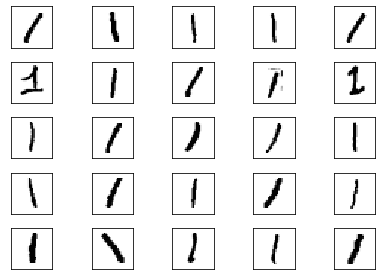

In [7]:
#Checking pictures of numbers
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 1][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [21]:
class NeuralNetMLP(object):

    def __init__(self, n_hidden=30, epochs=100, eta=0.001 ,shuffle=True, minibatch_size=1000, seed=None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        
#encoding onehot vector for output [0,1,0,0..], [1,0,0,0..] 1 represent right label
    def _onehot(self, y, n_classes):
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
#activation function
#http://neuralnetworksanddeeplearning.com/chap1.html#sigmoid_neurons
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
#forward propagation calculate output
        z_h = np.dot(X, self.w_h) + self.b_h
        a_h = self._sigmoid(z_h)
        z_out = np.dot(a_h, self.w_out) + self.b_out
        a_out = self._sigmoid(z_out)
        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
#cross-entropy cost function
#http://neuralnetworksanddeeplearning.com/chap3.html#the_cross-entropy_cost_function
        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2)
        return cost

    def predict(self, X):
#predicting output
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred
    
#training the model
    def fit(self, X_train, y_train):
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]

        ########################
        # weights initiation
        ########################

#calculating weights for hidden layer
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))
#calculating weights for output layer
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,size=(self.n_hidden, n_output))
#calculating onehot matrix for training data set
        y_train_enc = self._onehot(y_train, n_output)
    
        self.eval_ = {'cost': [], 'train_acc': []}

        # iterating through epochs
        for i in range(self.epochs):

            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)
#dividaing training data set into minibatches                
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                ##################
                # Forward propagation
                ##################
    
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # Backword propagation
                ##################

#calculating partial derivatives gradients for weights update
#http://neuralnetworksanddeeplearning.com/chap2.html
                sigma_out = a_out - y_train_enc[batch_idx]
                sigmoid_derivative_h = a_h * (1. - a_h)
                sigma_h = (np.dot(sigma_out, self.w_out.T) * sigmoid_derivative_h)

                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

#calculating delta for hidden weights and update
                delta_w_h = grad_w_h
                delta_b_h = grad_b_h
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

#calculating delta for output weights and update
                delta_w_out = grad_w_out
                delta_b_out = grad_b_out
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # Calculating cost
            #############

            z_h, a_h, z_out, a_out = self._forward(X_train)
            cost = self._compute_cost(y_enc=y_train_enc, output=a_out)

            y_train_pred = self.predict(X_train)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
            
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)

        return self

In [22]:
NN = NeuralNetMLP(n_hidden=30, epochs=5, eta=0.001, minibatch_size=1000)
NN.fit(X_train, y_train)

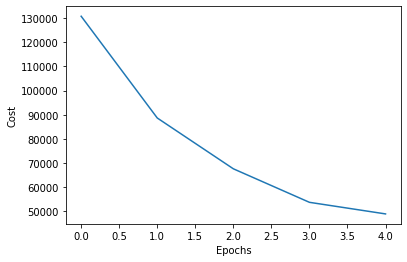

In [23]:
import matplotlib.pyplot as plt

plt.plot(range(NN.epochs), NN.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

In [24]:
y_pred = NN.predict(X_test)
accuracy_score(y_test, y_pred)

0.885

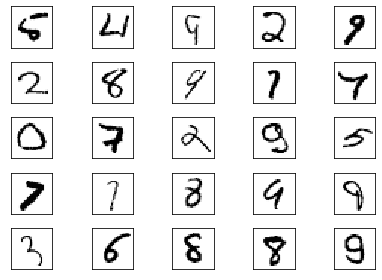

In [25]:
#numbers wrongly classified
miscl_img = X_test[y_test != y_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()